# 1. FETCH DATA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 

# Load the data from CSV file
# https://fred.stlouisfed.org/series/DGS10
Treasury_10Y_dataFrame = pd.read_csv("./Treasury_10Y.csv")

# Convert 'DATE' column to datetime type
Treasury_10Y_dataFrame['DATE'] = pd.to_datetime(Treasury_10Y_dataFrame['DATE'])

# Set 'DATE' as index for time series analysis
Treasury_10Y_dataFrame.set_index('DATE', inplace=True)

# Filter the DataFrame to include data only up to the end of 2020
Treasury_10Y_dataFrame = Treasury_10Y_dataFrame[Treasury_10Y_dataFrame.index <= '2020-12-31']

# Basic descriptive statistics to identify any obvious anomalies
Treasury_10Y_dataFrame.describe()

,DGS10
count,10697
unique,1370
top,.
freq,446


In [2]:
import pandas as pd
import numpy as np
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Replace '.' with NaN
Treasury_10Y_dataFrame['DGS10'].replace('.', np.nan, inplace=True)
Treasury_10Y_dataFrame['DGS10'].fillna(method='ffill', inplace=True)

# Convert the column to a numerical data type
Treasury_10Y_dataFrame['DGS10'] = pd.to_numeric(Treasury_10Y_dataFrame['DGS10'])

# Observe data
print(Treasury_10Y_dataFrame)

# Basic descriptive statistics to identify any obvious anomalies
Treasury_10Y_dataFrame.describe()


            DGS10
DATE             
1980-01-02  10.50
1980-01-03  10.60
1980-01-04  10.66
1980-01-07  10.63
1980-01-08  10.57
...           ...
2020-12-25   0.94
2020-12-28   0.94
2020-12-29   0.94
2020-12-30   0.93
2020-12-31   0.93

[10697 rows x 1 columns]


,DGS10
count,10697.00000
mean,5.90443
std,3.36525
min,0.52000
25%,3.07000
50%,5.28000
75%,7.98000
max,15.84000


# 2. EXPLORATORY DATA ANALYSIS


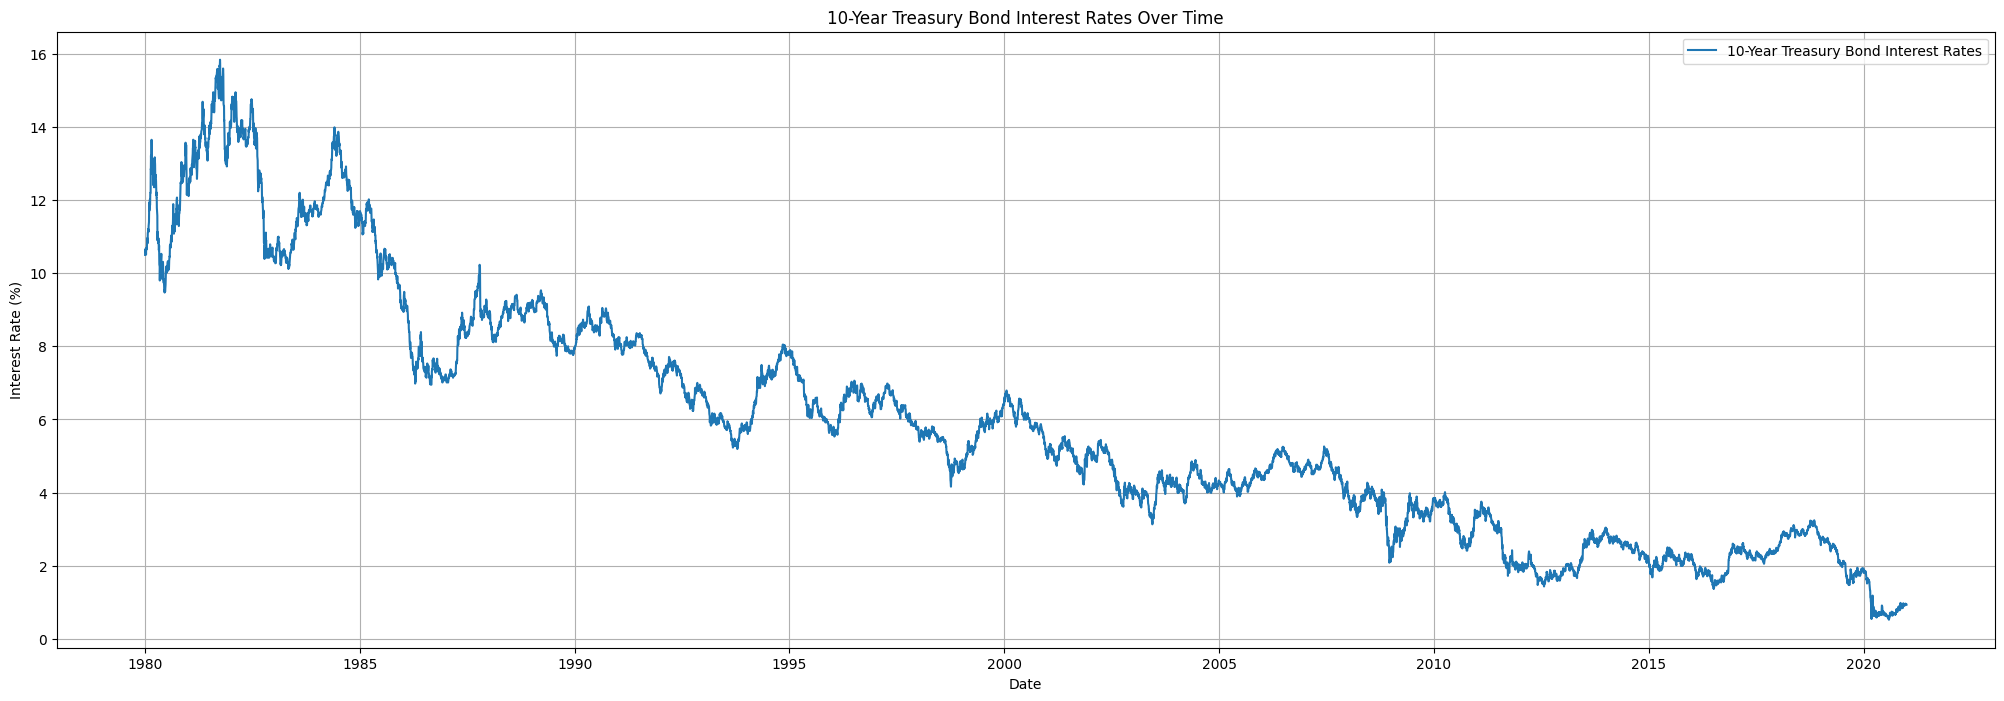

In [3]:
import matplotlib.pyplot as plt

# Assuming Treasury_10Y_dataFrame is your DataFrame with 'DGS10' as the column of interest
plt.figure(figsize=(25, 8))  # Set the size of the plot
plt.plot(Treasury_10Y_dataFrame.index, Treasury_10Y_dataFrame['DGS10'], label='10-Year Treasury Bond Interest Rates')
plt.title('10-Year Treasury Bond Interest Rates Over Time')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Interest Rate (%)')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Add a grid for easier reading
plt.show()  # Display the plot


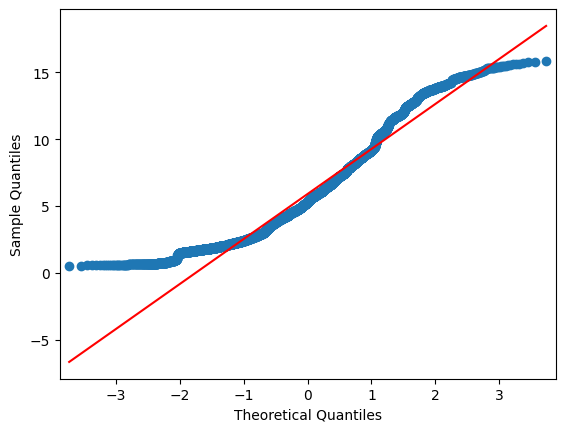

In [4]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# QQ-plot to check for normality
sm.qqplot(Treasury_10Y_dataFrame['DGS10'], line='s')
plt.show()



### QQ-PLOT
Middle Section (Around the Mean): The points in the middle section of the QQ plot (near the 0 of the theoretical quantiles) follow the red line quite closely, which suggests that the central part of the data is close to normally distributed.

Lower and Upper Tails: The lower tail (left side) of the distribution shows that the sample quantiles fall below the theoretical line, indicating that the data has lighter tails than the normal distribution in this region. The upper tail (right side) of the distribution deviates above the theoretical line, indicating heavier tails than the normal distribution. This suggests that there are more extreme values at both ends of the distribution than you would expect with a normal distribution.

Overall Shape: The 'S' shape of the plot, where the sample quantiles curve above the line on the right and below the line on the left, is indicative of a distribution that is skewed compared to the normal distribution. In this case, the presence of skewness suggests that the data may have a right skew (long tail on the right).

In summary, while the central part of your data may resemble a normal distribution, the tails do not. The data has lighter tails on the lower end and heavier tails on the upper end than would be expected if the data were perfectly normal. This might indicate the presence of outliers, or it might suggest that a different distribution would better describe the dataset. It’s also worth noting that financial and economic data often have such characteristics, and specialized time series models can account for this non-normality.

GARCH models can handle volatility clustering and are suitable for financial time series with heavy tails.
Also, many time series techniques, particularly those based on ARIMA (AutoRegressive Integrated Moving Average) or its variants, do assume normality of residuals, but they can often handle data that is not perfectly normal, especially if the non-normality is primarily in the tails.

In [5]:
from statsmodels.tsa.stattools import adfuller

# Performing the Augmented Dickey-Fuller test
adf_test_result = adfuller(Treasury_10Y_dataFrame['DGS10'])

# Extracting the p-value for interpretation
p_value = adf_test_result[1]
print(p_value)


0.3857057834644369


Non-stationary data can be problematic for many time series forecasting methods, as they assume that the statistical properties of the series (mean, variance, autocorrelation, etc.) do not change over time. Therefore, it is often recommended to transform non-stationary data to make it stationary before applying such methods.

# 3. CLEAN DATA

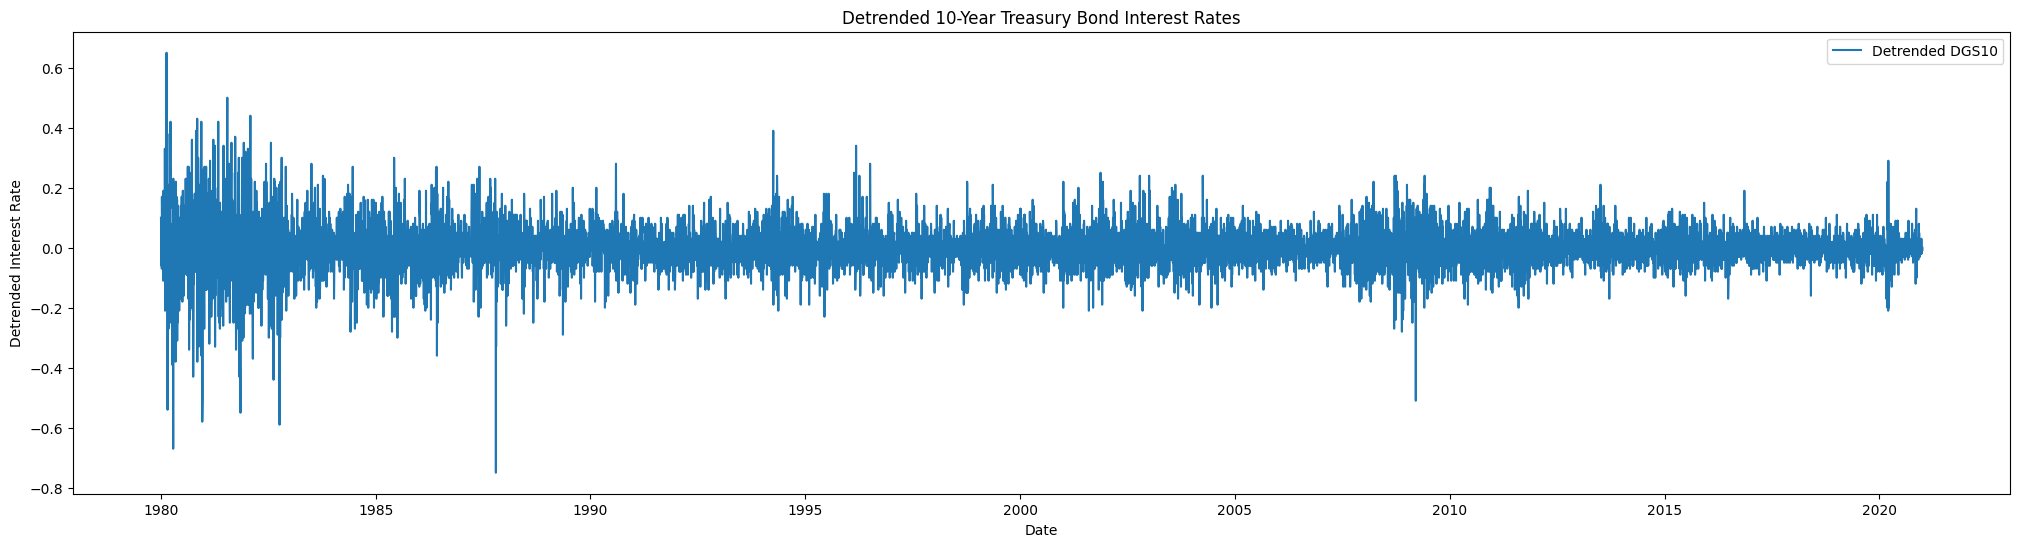

In [6]:
# Apply differencing to the 'DGS10' column
Treasury_10Y_dataFrame['DGS10_detrended'] = Treasury_10Y_dataFrame['DGS10'].diff().dropna()


# Now we should plot the detrended data to visualize the result
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6))
plt.plot(Treasury_10Y_dataFrame['DGS10_detrended'], label='Detrended DGS10')
plt.title('Detrended 10-Year Treasury Bond Interest Rates')
plt.xlabel('Date')
plt.ylabel('Detrended Interest Rate')
plt.legend()
plt.show()

In [7]:
# Drop NaN values and reassign the column back to the DataFrame
Treasury_10Y_dataFrame = Treasury_10Y_dataFrame.dropna(subset=['DGS10_detrended'])

print(Treasury_10Y_dataFrame['DGS10_detrended'].isna().sum())

0


In [8]:
from statsmodels.tsa.stattools import adfuller

# Performing the Augmented Dickey-Fuller test on the non-NaN data
adf_test_result = adfuller(Treasury_10Y_dataFrame['DGS10_detrended'])

# Extracting the p-value for interpretation
p_value = adf_test_result[1]
print(f'ADF Test p-value: {p_value}')


ADF Test p-value: 4.3244592387048745e-30


With the help of Augmented Dickey-Fuller (ADF) test, the reported p-value is approximately $4.32 \times 10^{-30}$, which is practically zero and far below any conventional significance level (e.g., 0.05 or 0.01). This extremely low p-value strongly suggests that the null hypothesis of the ADF test (which posits that the time series has a unit root and is non-stationary) can be rejected.

In other words, the data does not have a unit root and is stationary, meaning that its statistical properties such as mean, variance, and autocorrelation are constant over time. This is a desirable property when using many time series analysis and forecasting techniques, as non-stationarity can lead to unreliable models and predictions

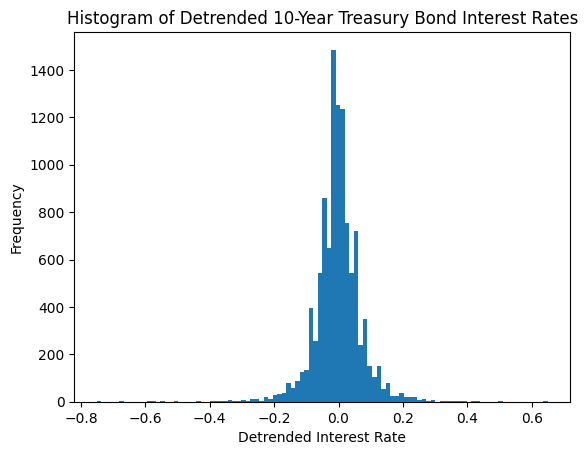

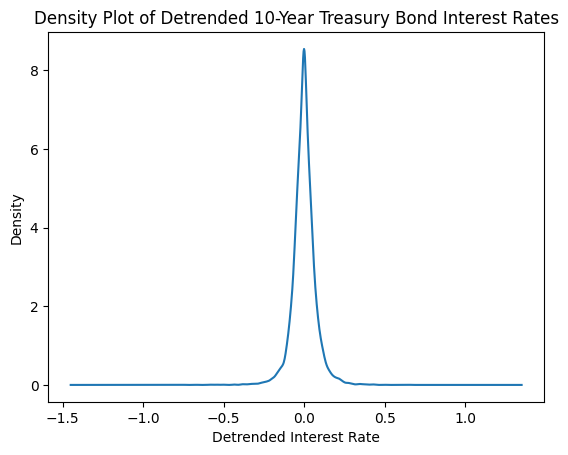

In [9]:
Treasury_10Y_dataFrame['DGS10_detrended'].plot(kind='hist', bins=100)
plt.title('Histogram of Detrended 10-Year Treasury Bond Interest Rates')
plt.xlabel('Detrended Interest Rate')
plt.show()

Treasury_10Y_dataFrame['DGS10_detrended'].plot(kind='density')
plt.title('Density Plot of Detrended 10-Year Treasury Bond Interest Rates')
plt.xlabel('Detrended Interest Rate')
plt.show()


Shape: The histogram shows a unimodal distribution, meaning there is a single peak. The distribution appears to be somewhat symmetric around the peak, but without seeing the tails more clearly, we cannot determine if it's perfectly symmetric.

Central Tendency: The peak of the histogram is around zero, which suggests that the detrended interest rates have a mean or median close to zero. This is expected for detrended data, where the trend has been removed to center the data around zero.

Spread: The range of the detrended interest rates seems to be between approximately -0.8 and +0.6. The majority of the data clusters around the mean, with fewer observations as you move away from the center.

Outliers: There do not appear to be significant outliers on either side of the distribution since the frequencies taper off as you move towards the extremes of the data range.

Skewness: From this view, the distribution does not seem to have a pronounced skew; however, without seeing the full range of the data, it's hard to make a definitive statement about skewness.

Kurtosis: The peak of the distribution is quite sharp, which may indicate leptokurtosis, suggesting that the data are more clustered around the mean than would be expected in a normal distribution, with fewer observations in the tails.

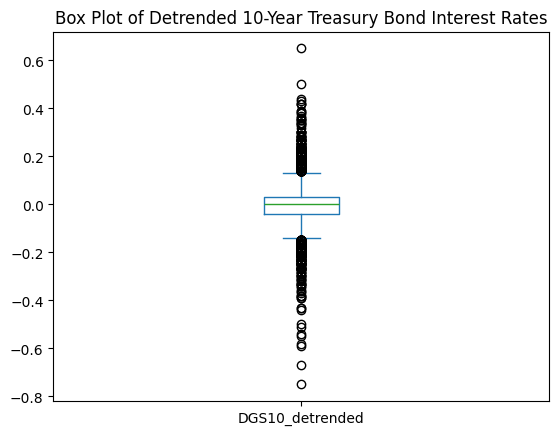

In [10]:
Treasury_10Y_dataFrame['DGS10_detrended'].plot(kind='box')
plt.title('Box Plot of Detrended 10-Year Treasury Bond Interest Rates')
plt.show()


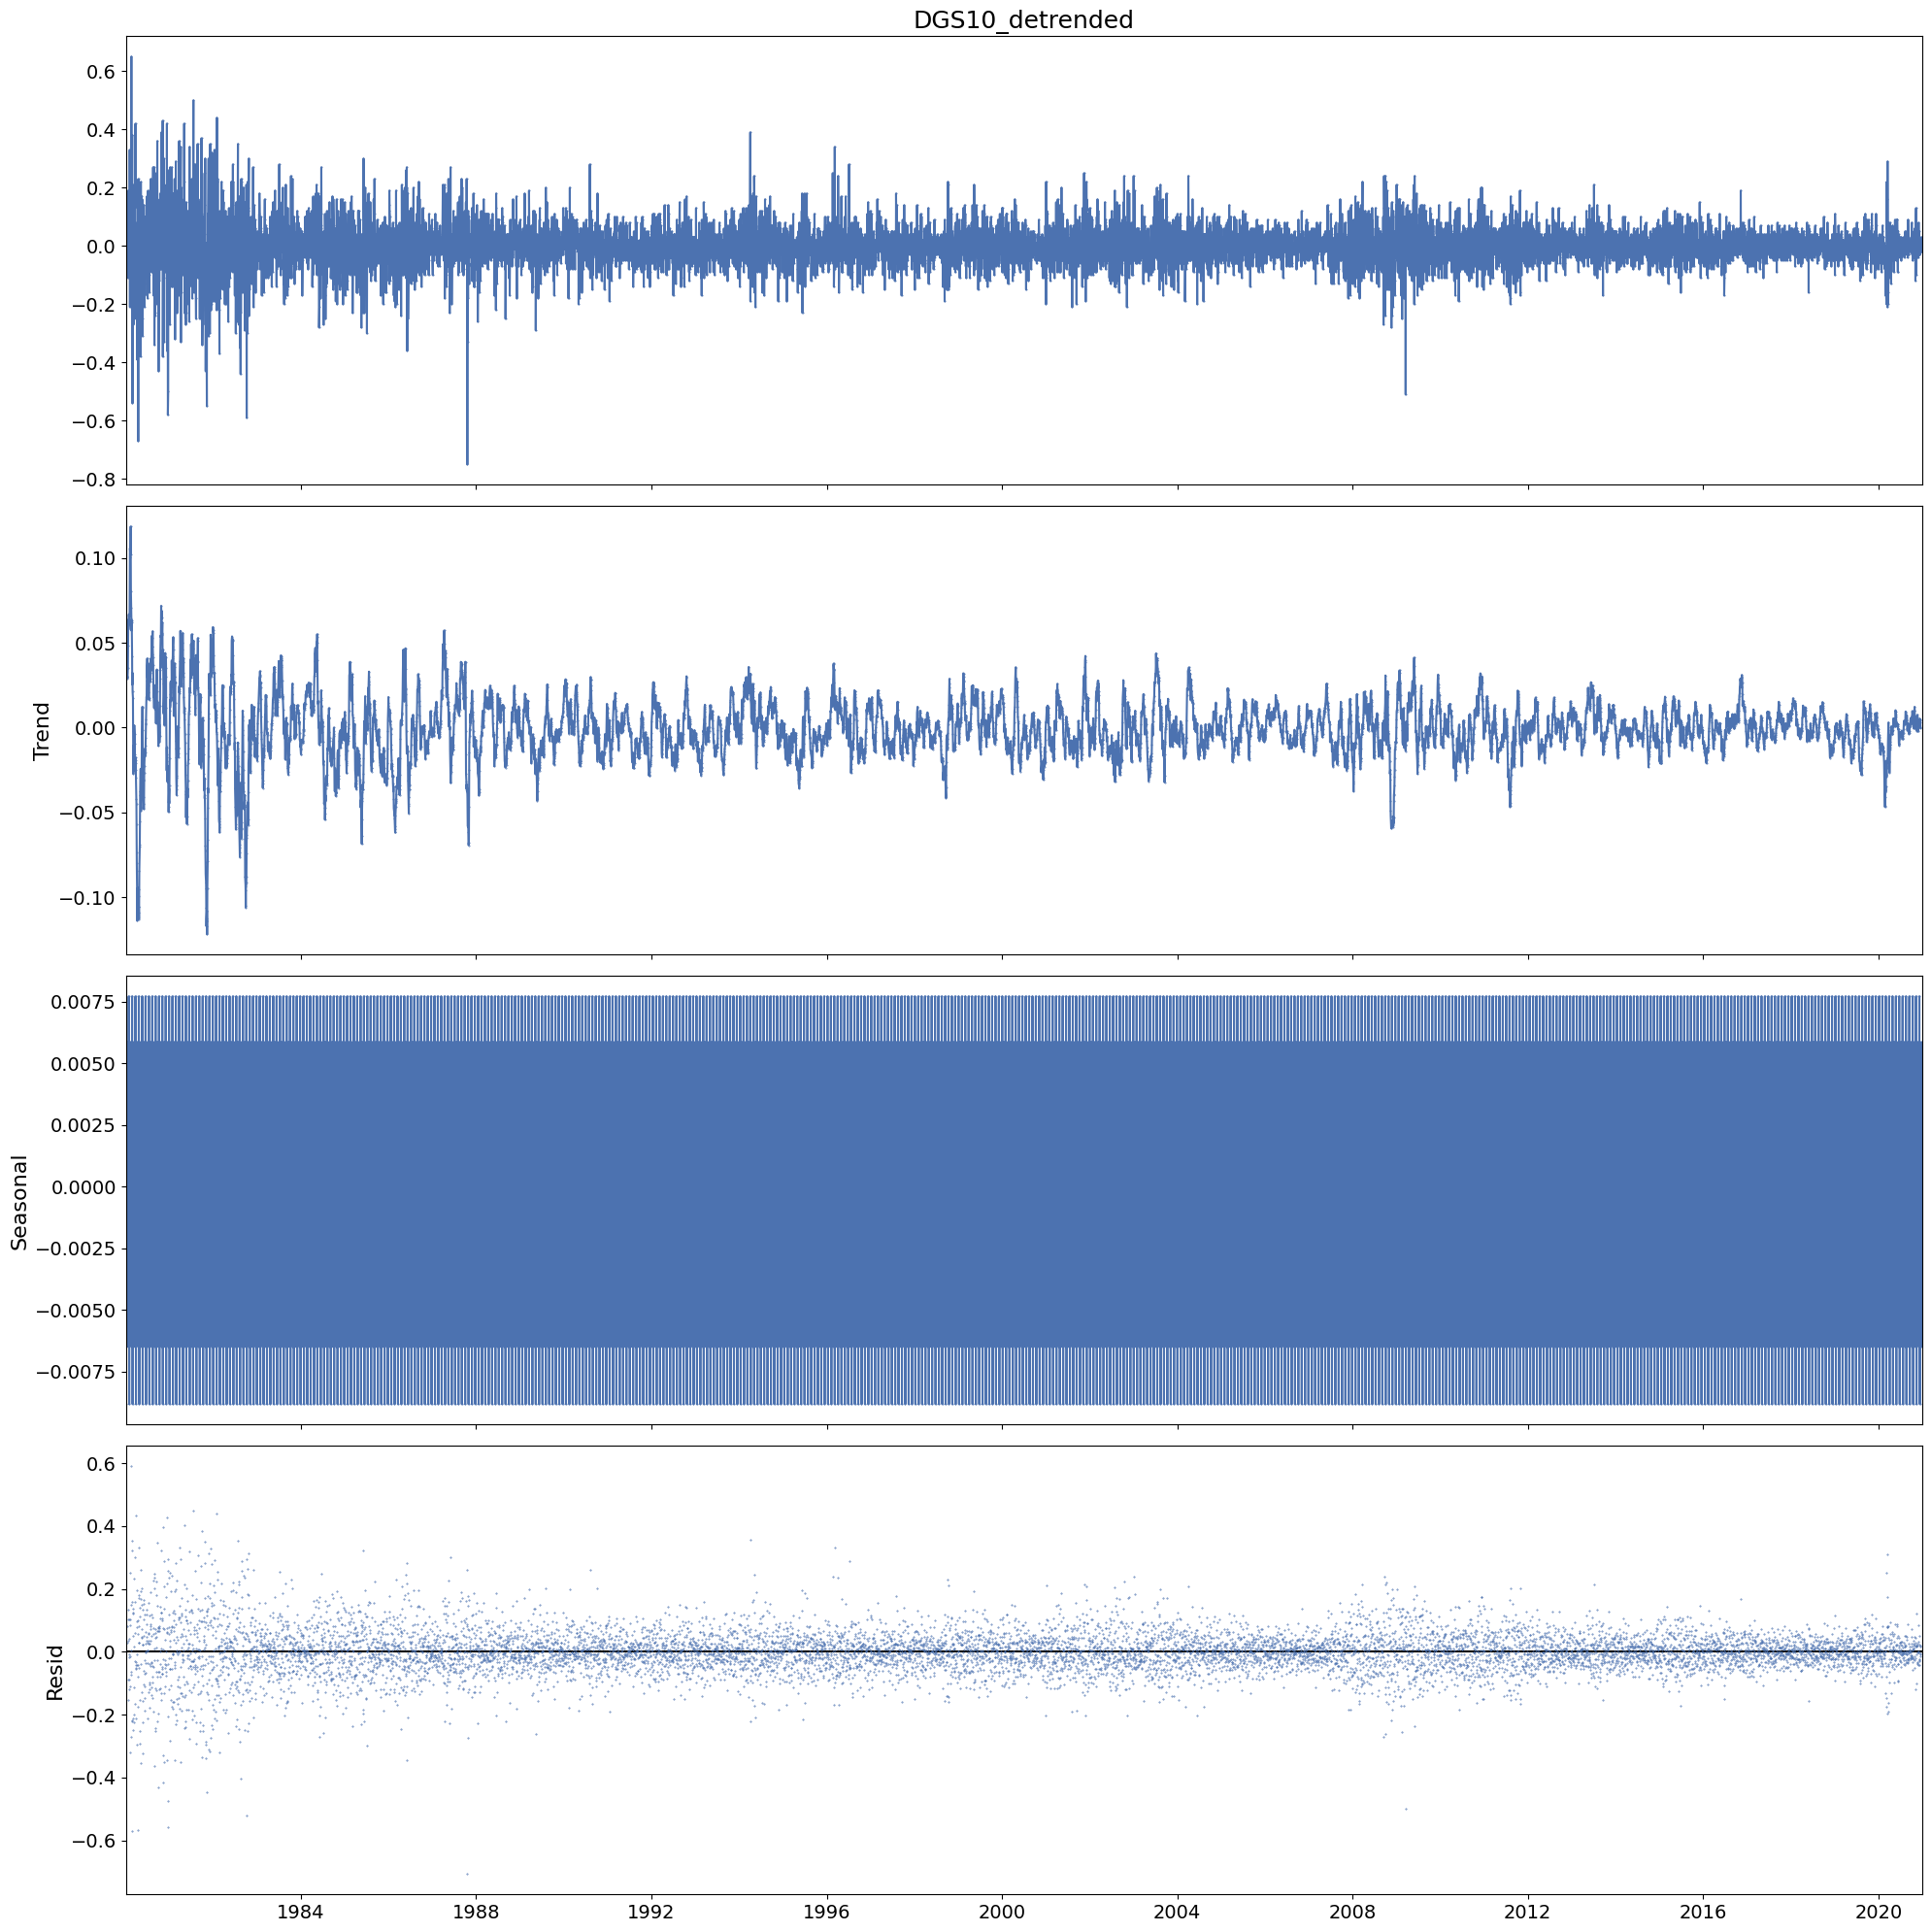

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn

# Assuming Treasury_10Y_dataFrame['DGS10_detrended'] is your series data
series_data = Treasury_10Y_dataFrame['DGS10_detrended']

# Perform seasonal decomposition
decomposition = seasonal_decompose(series_data, model='additive', period=20)

# Apply the seaborn style
plt.style.use('seaborn-v0_8-deep')

# Plot the seasonal decomposition and set the figure size directly in the plot method
fig = decomposition.plot()
fig.set_size_inches(20, 20)  # Set the figure size here

# Customize each subplot to adjust the aesthetics
for ax in fig.get_axes():
    # Set larger font sizes for better readability
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    # Customize the dots in the residual plot if necessary
    if hasattr(ax, 'lines'):
        for line in ax.get_lines():
            line.set_marker('.')  # Set marker style
            line.set_markersize(0.8)  # Make the dots smaller
    
    # Set the labels with larger font size
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=18)

# Adjust the layout to fit everything neatly
plt.tight_layout()
plt.show()


**Trend Component:** The trend component captures the long-term progression of the series. In this case, the trend seems to be relatively stable around a certain level, without clear direction, indicating that the long-term trend has been largely removed through prior detrending.

**Seasonal Component:** The seasonal component captures regular, periodic fluctuations in the time series. The amplitude of the seasonal component seems very low, which suggests that there might be minimal or no seasonality present in the data, or the seasonal fluctuations are very subtle.

**Residual Component:** The residual component captures the irregularities in the data that are not explained by the trend or seasonal components. In this plot, the residuals show some volatility, but there is no apparent pattern. The spread of residuals seems fairly constant over time, although there may be some periods with larger fluctuation

# 4. ACF and PACF

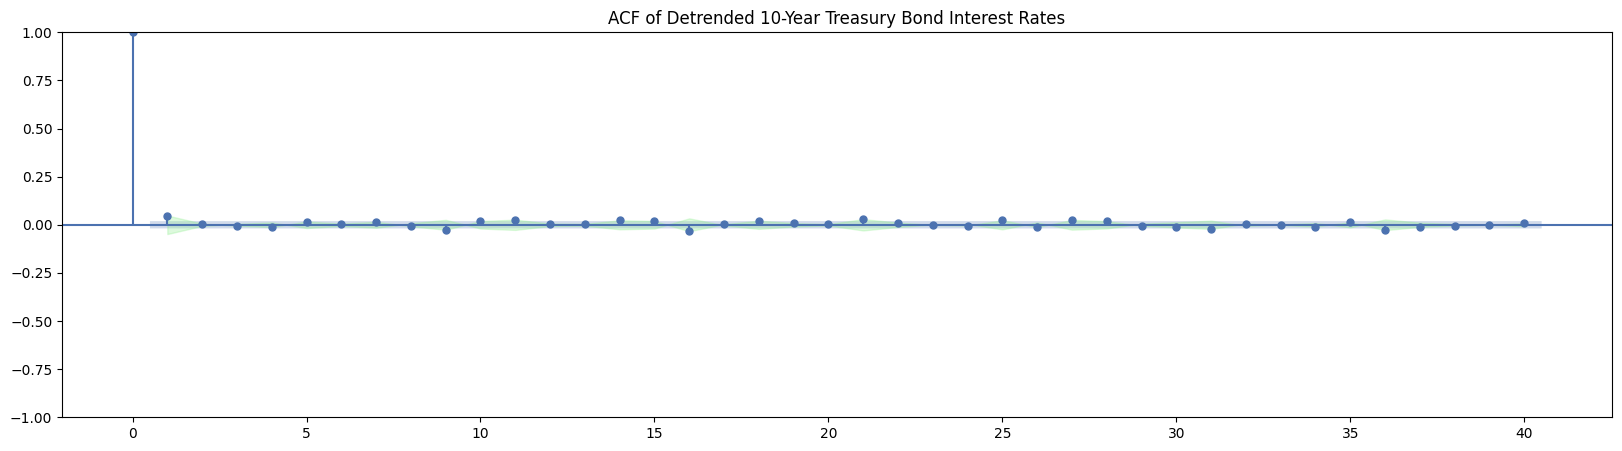

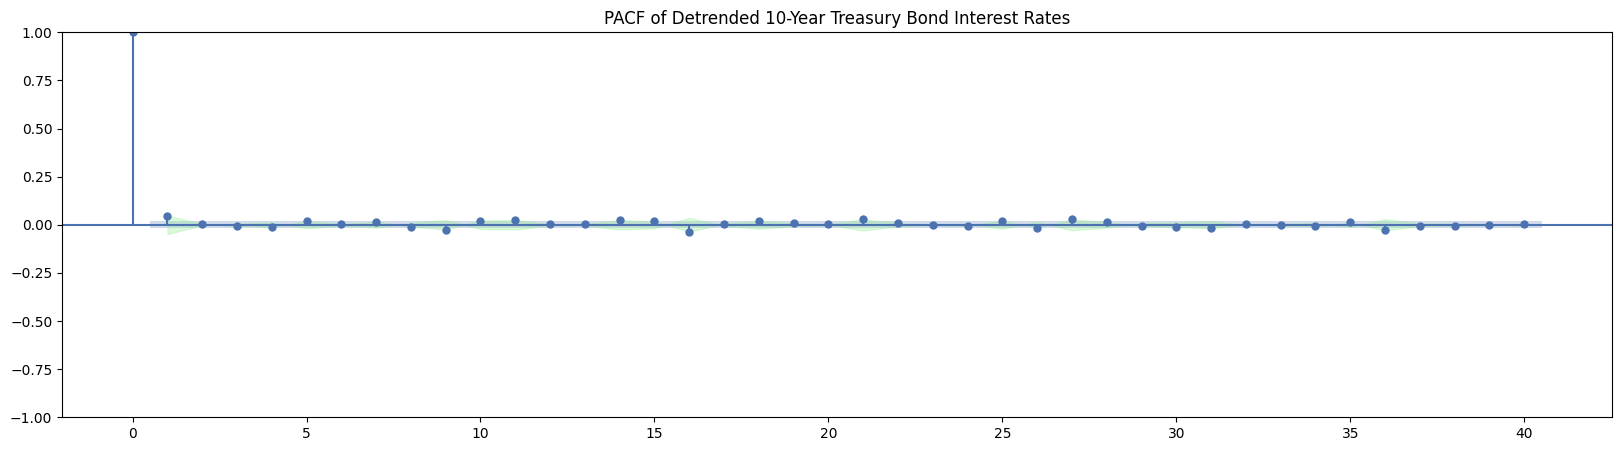

In [12]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

# Assuming Treasury_10Y_dataFrame['DGS10_detrended'] is your series data
series_data = Treasury_10Y_dataFrame['DGS10_detrended']

# Apply the seaborn style
plt.style.use('seaborn-v0_8-deep')

# Customize the ACF plot
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(series_data, ax=ax, lags=40, alpha=0.05, title='ACF of Detrended 10-Year Treasury Bond Interest Rates')

# Add a light green fill under the confidence interval
confint = ax.get_lines()[1].get_ydata()[1:] - ax.get_lines()[0].get_ydata()[1:]
ax.fill_between(x=np.arange(1, 41), y1=-confint, y2=confint, color='lightgreen', alpha=0.3)

# Customize the PACF plot
fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(series_data, ax=ax, lags=40, alpha=0.05, title='PACF of Detrended 10-Year Treasury Bond Interest Rates')

# Add a light green fill under the confidence interval
confint = ax.get_lines()[1].get_ydata()[1:] - ax.get_lines()[0].get_ydata()[1:]
ax.fill_between(x=np.arange(1, 41), y1=-confint, y2=confint, color='lightgreen', alpha=0.3)

plt.show()


## ACF
Initial Lag: There is a significant spike at the initial lag (lag 0), which is always 1 because it's the correlation of the series with itself.

Subsequent Lags: The autocorrelation coefficients for subsequent lags quickly drop off and hover around zero. This indicates there is little to no autocorrelation in the time series at these lags.

Stationarity Implication: The rapid decline and flattening of the ACF suggest that the time series is likely stationary, which is supported by the fact that the ACF values fall within the confidence interval (not shown, but typically represented by a blue shaded area or horizontal lines at the top and bottom).

Modeling Considerations: The lack of significant peaks in the ACF plot also implies that an autoregressive model may not be useful for capturing any structure in this series because there's no evidence of autoregressive behavior.

Randomness: The scatter of autocorrelation coefficients around zero for higher lags is consistent with what you might expect from a white noise series, where data points are uncorrelated with each other.

Overall, the ACF plot suggests that the detrended 10-Year Treasury Bond Interest Rates do not exhibit autocorrelation across different lags, and thus, the series may be modeled as a random walk or may require other forms of analysis to understand its behavior better

## PACF

Initial Lag: The partial autocorrelation at lag 0 is always 1, as each point is perfectly correlated with itself.

Subsequent Lags: The PACF expresses the correlation between observations of a time series that are separated by various numbers of time lags, after accounting for the correlations at all lower-lag order correlations. In this plot, the partial autocorrelations are very close to zero for all lags beyond the immediate first one. This indicates that there is little to no correlation between the values separated by various time lags, once the correlation due to the intervening values has been removed.

Significance: The lack of significant spikes in the plot (beyond the first lag) suggests that there are no strong partial autocorrelations in the time series at those lag intervals. This is typical for a series where the present value is not significantly dependent on the values at previous time steps, other than through what could be explained by the immediate past value.

Modeling Implications: From a modeling perspective, this could imply that an AR(p) model, where 'p' is the order of the autoregressive terms, might not be particularly useful beyond p=1, as there does not seem to be information in the past data that would help predict future values.

Stationarity: Similar to the ACF plot, the PACF plot suggests that the series is likely stationary, given that the correlations die out quickly.

Data Noise: The scatter of the partial autocorrelation coefficients around zero for the higher lags suggests that what remains in the series after removing the trend is likely noise.

In summary, the PACF plot supports the suggestion that the detrended time series does not exhibit strong autocorrelations and may be considered stationary. It also indicates that a simple autoregressive model would likely not improve much on a naive forecast for future values.